In [1]:
import sys
sys.path.insert(0, '../')
from lib import *

%matplotlib inline

## Multiple runs

In [2]:
path="/media/rodrigoa/DiscoDuro/SBND_XA_PDE/APSAIA_VIS/joython/"
Run_props=open_run_properties(0,"../macros/APSAIA_VIS.xlsx")
Runs=open_runs_table("../macros/APSAIA_VIS.xlsx")


# path="/media/rodrigoa/DiscoDuro/SBND_XA_PDE/APSAIA_VUV/joython/"
# Run_props=open_run_properties(0,"../macros/APSAIA_VUV.xlsx")
# Runs=open_runs_table("../macros/APSAIA_VUV.xlsx")

Runs=Runs[Runs["Type"]=="Alfa"]


amp  =np.zeros((len(Run_props["Channels"]),Runs["Run"].array.shape[0]))
mean =np.zeros((len(Run_props["Channels"]),Runs["Run"].array.shape[0]))
err  =np.zeros((len(Run_props["Channels"]),Runs["Run"].array.shape[0]))
rate =np.zeros((len(Run_props["Channels"]),Runs["Run"].array.shape[0]))

i=0

for ch in Run_props["Channels"]:
# for ch in [0]:
    r=0;
    for run in Runs["Run"].array:
    # for run in [0]:
        
        Run_props=open_run_properties(run,"../macros/APSAIA_VUV.xlsx")
        run_path=path+"run"+str(run).zfill(2)+"/";
        compress=False
        Pedestal_vars=open_run_var(run_path,"Pedestal_vars",[ch],compressed=compress)
        Charge_vars  =open_run_var(run_path ,"Charge_vars" ,[ch],compressed=compress)
        Peak_vars    =open_run_var(run_path ,"Peak_vars"   ,[ch],compressed=compress)
        TS=open_run_var(run_path,"Timestamp",[ch],compressed=compress)

        Ped_CUT=Pedestal_vars[ch]["STD"]<10
        counts,bins=np.histogram(Charge_vars[ch]["ChargeRange"][Ped_CUT*Peak_vars[ch]["Peak"]>40],100,[0,3e4]);

        std=np.std(Charge_vars[ch]["ChargeRange"][Ped_CUT*Peak_vars[ch]["Peak"]>40])

        popt, pcov = curve_fit(gauss, bins[1:], counts,p0=[max(counts),bins[np.argmax(counts)],std])
        
        
        ym = gauss(bins[1:], popt[0], popt[1], popt[2])
        # plt.plot  (bins[1:], ym, c='r', label='Best fit')
        amp [i,r]=popt[0]
        mean[i,r]=popt[1]
        err [i,r]=popt[2]
        
        duration=(TS[ch][-1]-TS[ch][0])
        rate[i,r]=np.sqrt(np.pi*2*popt[2]**2)*popt[0]*100/3e4/duration #gauss integral divided by bin tickness
        r+=1;
    i+=1;


x=Runs["Run"].array
ys=mean[:4]
yer=err[:4]
legend=Run_props["ChannelName"][:4]

fig,axs=horizontal_subplots(x,ys,yer,legend)
plt.suptitle("Charge over Runs", fontsize=14)
axs[0].set_ylabel("Charge,[ADCs x ticks]")
for ax in axs: ax.set_ylim([2,20000])

plt.figure()
ys=rate[:4]
yer=np.zeros(ys.shape)
fig,axs=horizontal_subplots(x,rate[:4],yer,legend)
plt.suptitle("Rate over Runs", fontsize=14)
for ax in axs: ax.set_ylim([25,35])



/home/rodrigoa/CYTHON_TOOLS_2/joython/joython_notebooks/../lib/dec_functions.py:12: RuntimeWarning: overflow encountered in power
  y = a*np.exp(-(x-mean)**n/(2*sigma**n))
/home/rodrigoa/CYTHON_TOOLS_2/joython/joython_notebooks/../lib/dec_functions.py:12: RuntimeWarning: overflow encountered in double_scalars
  y = a*np.exp(-(x-mean)**n/(2*sigma**n))
/home/rodrigoa/CYTHON_TOOLS_2/joython/joython_notebooks/../lib/dec_functions.py:12: RuntimeWarning: invalid value encountered in divide
  y = a*np.exp(-(x-mean)**n/(2*sigma**n))
/home/rodrigoa/CYTHON_TOOLS_2/joython/joython_notebooks/../lib/dec_functions.py:12: RuntimeWarning: invalid value encountered in power
  y = a*np.exp(-(x-mean)**n/(2*sigma**n))
/home/rodrigoa/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/rodrigoa/CYTHON_TOOLS_2/joython/joython_notebooks/../lib/dec

FileNotFoundError: [Errno 2] No such file or directory: '/media/rodrigoa/DiscoDuro/SBND_XA_PDE/APSAIA_VIS/joython/run07/Timestamp_ch0.npy'

In [ ]:
rate[0]

array([28.38787715, 31.32597546, 28.54391669, 30.60050305, 28.73673226,
       30.62928438, 28.55502504, 29.64915722, 28.06675562, 29.84734698,
       28.19779609, 30.00988133, 28.39094175, 30.3080102 , 28.07064494,
       29.25822785, 27.846812  , 29.07423016, 27.88566834, 27.90472646])

## Single Run

3925046.744152409


(1, 1000.0)

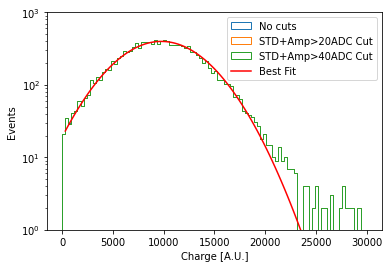

In [ ]:
# Let's create a function to model and create data

for ch in [0]:
    r=0;
    # for run in Runs["Run"].array:
    for run in [0]:
        Run_props=open_run_properties(run,"../macros/APSAIA_VUV.xlsx")
        run_path=path+"run"+str(run).zfill(2)+"/";
        compress=False
        Pedestal_vars=open_run_var(run_path,"Pedestal_vars",[ch],compressed=compress)
        Charge_vars  =open_run_var(run_path ,"Charge_vars" ,[ch],compressed=compress)
        Peak_vars    =open_run_var(run_path ,"Peak_vars"   ,[ch],compressed=compress)

def gauss(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))


Ped_CUT=Pedestal_vars[0]["STD"]<6

plt.hist(Charge_vars[0]["ChargeRange"]                         ,100,[0,3e4],histtype="step");
plt.hist(Charge_vars[0]["ChargeRange"][Ped_CUT*Peak_vars[0]["Peak"]>20],100,[0,3e4],histtype="step");
plt.hist(Charge_vars[0]["ChargeRange"][Ped_CUT*Peak_vars[0]["Peak"]>40],100,[0,3e4],histtype="step");
counts,bins=np.histogram(Charge_vars[0]["ChargeRange"][Ped_CUT*Peak_vars[0]["Peak"]>40],100,[0,3e4]);

std=np.std(Charge_vars[0]["ChargeRange"][Ped_CUT*Peak_vars[0]["Peak"]>40])

popt, pcov = curve_fit(gauss, bins[1:], counts,p0=[max(counts),bins[np.argmax(counts)],std])


print(sum(gauss(np.arange(0,1e8),popt[0], popt[1], popt[2])) ) 

ym = gauss(bins[1:], popt[0], popt[1], popt[2])
plt.plot  (bins[1:], ym, c='r', label='Best fit')

plt.semilogy()

plt.legend(["No cuts","STD+Amp>20ADC Cut","STD+Amp>40ADC Cut","Best Fit"])
plt.xlabel("Charge [A.U.]")
plt.ylabel("Events")
plt.ylim([1,1e3])
